In [1]:
import os
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import geopandas as gpd
from shapely.geometry import Point, Polygon, MultiPolygon
%matplotlib inline

from IPython.core.display import display, HTML
pd.options.display.max_columns = 999
display(HTML("<style>.container { width:85% !important; }</style>"))

/var/folders/g4/ykwfgyl55t7dfzv_zc3dcshh0000gn/T/ipykernel_1692/2176066093.py:11: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
vacant = pd.read_csv("https://data.cityofchicago.org/resource/kc9i-wq85.csv")
vacant['geometry'] = vacant.apply(lambda row: Point(float(row['longitude']), float(row['latitude'])), axis=1)
vacant_gdf = gpd.GeoDataFrame(vacant, geometry='geometry')

### 1.1 Load Data Path
Use `pandas` to load data for **crime occurrences** in Chicago, Illinois/Cook County during the time periods of **2019 to 2022** utilizing a file merger. Additionally, read in a `csv` file made in the walkscore metric jupyter notebook file.

In [3]:
path = "data/"
file_name = ['chicago_2019.csv', 'chicago_2020.csv', 'chicago_2021.csv', 'chicago_2022.csv']
filenames =[path + file for file in file_name]

""" 
    Modifies: df
    Read Me: Basic File Merger, to combine the 2019-2022 census data
    Requires: A file path list, file path may need to be modified accordingly, to fit folder structure
"""
def fileMerger(path):
    df1 = pd.read_csv(path[0])
    df2 = pd.read_csv(path[1])
    df_merged = df1.merge(df2, how='outer')
    for file in path[2:]:
        temp = pd.read_csv(file)
        df_merged = df_merged.merge(temp, how='outer')
    return df_merged

df = fileMerger(filenames)

# access the processed place of interest data
walkability = pd.read_csv("poi_data_processed.csv")
walkability = walkability.drop(['Unnamed: 0'], axis=1)
if walkability.shape[1] == 3:
    print(f"Success loading a dataframe with {df.shape[0]} rows.")
    print(df.shape, walkability.shape)

Success loading a dataframe with 922148 rows.
(922148, 22) (77, 3)


### 1.2 Begin to Explore Data / Preprocessing?
Our csv file `df` contains much of the crime data. Each row represents a single case of crime. Somehow, we should separate our data into one that is indexed by a *date-time* component and another that will take in a geojson code, for better mapping capabilities.

For now, we should probably figure where some NaN's are coming from. Additionally, we know this data is heavily imbalanced, so we must do something to it, in order to make more accurate predicitons later on.

In [4]:
# remove unneccessary columns
df.drop(['Case Number', 'IUCR','Updated On', 'FBI Code'], inplace=True, axis=1)

<Axes: >

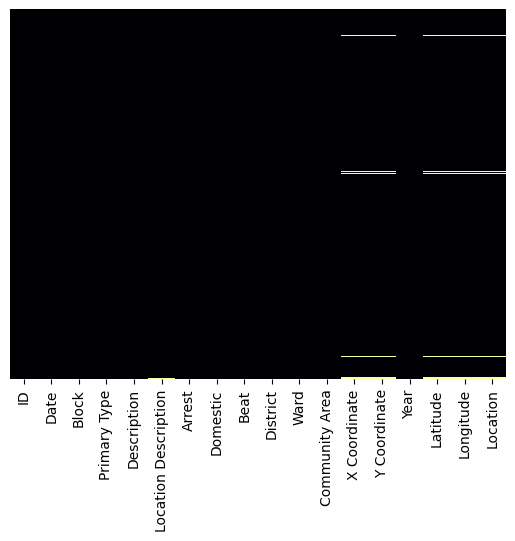

In [5]:
sb.heatmap(data=df.isna(), yticklabels=False, cbar=False, cmap='inferno')

Based upon the premise of this heatmap, we have some missing information for `location/positional` encoding data. We will separate our dataframe into two, one being a time-based data, where we will in fact drop all the locations. On the second dataframe, we will rather keep these NaN values, since these most likely represent a specific type(s) of crime that did not likely have any positional encoding data, e.g., online theft, theft in general where an arrest was NOT made, etc. 

In [6]:
# Converting Community Area Code to an Community Name
"""
This allows us to explore data much effectively, being able
to scrape further information outside of just a code, such as
exploring real estate property indices in each community, and
make inferences regarding average home sale price and its corresponding community.
"""
import requests
url = "https://www.chicagotribune.com/2002/12/04/chicago-communities-17/"
text = requests.get(url).text

tables = pd.read_html(url)
print("Found {} tables in Source[{}]".format(len(tables), url))
hash = {"Community Area" : ["nan", "nan"], "Community Name": ["NaN", "NaN"]}

community = tables[1]

for item in (community):
    # community index
    if(item == 0 or item == 2):
        for i in range(len(community[item])):
                community[item] = community[item].astype(float)
                hash['Community Area'].append(community[item][i])
    if(item == 1 or item == 3):
        for i in range(len(community[item])):
                community[item] = community[item].astype(str)
                #print(community[item][i])
                hash['Community Name'].append(community[item][i])

def applyName(x):
    for item in range(len(hash["Community Area"])):
        if x == hash["Community Area"][item]:
            return hash["Community Name"][item].upper()
df["Community Name"] = df['Community Area'].apply(applyName)

# Check the Community Name Output
df['Community Name'] 

Found 4 tables in Source[https://www.chicagotribune.com/2002/12/04/chicago-communities-17/]


0         GRAND BOULEVARD
1         GRAND BOULEVARD
2               WEST TOWN
3          WEST ENGLEWOOD
4                CLEARING
               ...       
922143    NEAR NORTH SIDE
922144        SOUTH SHORE
922145     AUBURN GRESHAM
922146       WEST PULLMAN
922147     SOUTH LAWNDALE
Name: Community Name, Length: 922148, dtype: object

In [7]:
# Fix O'Hare's naming to match the walkscore csv's format
for i, names in enumerate(walkability['Community Name']):
    if names == 'OHARE':
        walkability['Community Name'][i] = 'O\'HARE'

def applyScore(iter):
    for i, community in enumerate(df['Community Name']):
        if community in walkability['Community Name']:
            for n in range(len(walkability)):
                if community == walkability['Community Name'][n]:
                    df['Walk'][i] = walkability['Walk_Score'][n]

df = df.merge(walkability[['Community Name', 'Walk_Score']], on='Community Name', how='left')
df.rename(columns={'Walk_Score': 'Walk'}, inplace=True)
df['Walk'] = df['Walk'].fillna(0)
df = df.merge(walkability[['Community Name', 'scaled_walkability']], on='Community Name', how='left')
df.rename(columns={'scaled_walkability': 'Scaled_Walk'}, inplace=True)
df['Scaled_Walk'] = df['Scaled_Walk'].fillna(0)

/var/folders/g4/ykwfgyl55t7dfzv_zc3dcshh0000gn/T/ipykernel_1692/2245773158.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  walkability['Community Name'][i] = 'O\'HARE'
/var/folders/g4/ykwfgyl55t7dfzv_zc3dcshh0000gn/T/ipykernel_1692/22457

In [8]:
# geometry for geopandas sf
df['geometry'] = df.apply(lambda row: Point(row['X Coordinate'], row['Y Coordinate']), axis=1)

temp = df.copy(deep=True)
df = df.dropna(subset=["Longitude", "Latitude", "Ward", "Community Area", "Location Description"])

df = df[(df['Longitude'] > -88) & (df['Longitude'] < -87) & (df['Latitude'] > 41) & (df['Latitude'] < 43)]

# For analysis purposes, conduct smaller analysis, let's run only 2019
df2019 = df[df['Year'] == 2019]
df2020 = df[df['Year'] == 2020]
df2021 = df[df['Year'] == 2021]
df2022 = df[df['Year'] == 2022]

In [9]:
#this is a deep copy of df, in order to ensure the NaN data to still remain present
df_time = temp.copy(deep=True)
df_time.index = pd.DatetimeIndex(df_time.Date)

### 1.3 GeoJson Configuration
Apply `Community Area` shape geometries back into our dataset, where each Community Name is matching. For every row with no locational data, we'll most likely drop for now. 

In [10]:
# establish shape file
sf = gpd.read_file('ch_geo.geojson')
sf.set_crs(epsg=4326, inplace=True)
sf = sf.set_geometry('geometry')

In [11]:
%%time
# policing shape file represents the one for 2019, geom is for all years, discrete naming
policing_sf = gpd.GeoDataFrame(df2019, geometry="geometry")
police_geom = gpd.GeoDataFrame(df, geometry="geometry")

# Set the CRS using the new syntax
policing_sf.set_crs(epsg=4326, inplace=True)
police_geom.set_crs(epsg=4326, inplace=True)

crimes_geo2019 = gpd.GeoDataFrame(pd.merge(policing_sf, sf, left_on='Community Name', right_on='community', how='left'))
crimes_df = gpd.GeoDataFrame(pd.merge(police_geom, sf, left_on='Community Name', right_on='community', how='left'))

CPU times: user 2.94 s, sys: 744 ms, total: 3.68 s
Wall time: 4.89 s


In [12]:
"""test = crimes_df[['Community Name', 'Block', 'Walk']]
test.loc[:, 'Crimes'] = 1
test = test.groupby(['Community Name']).sum().reset_index()
test.sort_values('Crimes', ascending = False).head()"""

"test = crimes_df[['Community Name', 'Block', 'Walk']]\ntest.loc[:, 'Crimes'] = 1\ntest = test.groupby(['Community Name']).sum().reset_index()\ntest.sort_values('Crimes', ascending = False).head()"

### 1.4 Time Based Data 
For the sake of conducting some potential regarding time series, in my project, I decided to set up a sepatate dataframe that will set the dataframe's index to each case's respective date-time variable. By analyzing crime occurrences with their specific timestamps, law enforcement agencies can identify patterns and trends that are time-specific. For instance, certain crimes may spike on specific days of the week, times of day, or during particular events or seasons. This precision allows for targeted policing efforts when and where they're most needed. To add on, law enforcement resources are often very limited. Time-indexed predictive policing enables agencies to allocate their resources more **efficiently**. Officers can be deployed in a more targeted manner, focusing on high-risk times and areas, which maximizes the impact of their presence and efforts.

In [13]:
df_time['Day'] = df_time.index
df_time['Month'] = df_time.index.month
df_time['DayOfWeek'] = df_time.index.dayofweek
df_time['HourOfDay'] = df_time.index.hour
df_time['DayOfMonth'] = df_time.index.day
df_time['DayOfYear'] = df_time.index.dayofyear
df_time['MonthYear'] = df_time.index.strftime('%Y-%m')
df_time['DayYear'] = df_time.index.strftime('%j-%Y')
df_time['WeekOfMonth'] = df_time.DayOfMonth.apply(lambda x: (x-1) // 7+1)
df_time = df_time.sort_index(ascending=True)

In [14]:
import math
dayOfYear = list(df_time.index.dayofyear)
weekOfYear = [math.ceil(x / 7) for x in dayOfYear]
df_time['WeekOfYear'] = weekOfYear

def hour(x):
    return int(x.strftime("%H"))
df_time['Hour'] = df_time['Day'].apply(hour)

### Grouping Prior to Moving Forward
Before moving into looking into the general overview of the dataset, we decided that it would be a good practice to group some main crimes by location-type attributes, given the weight of importance it may have later on in conducting actual statistical computation(s) and predictive modeling on a smaller set data. However, this data will remain `imbalanced` for sure given the nature of the main dataframe being extensively large with some crime-types having more occurrences compared to others which may be more niche like "witchcraft" for say.

In [15]:
"""General Grouping"""
ch5 = df_time.groupby(['Month','DayOfWeek','District','Hour'], as_index=False).agg({"Primary Type":"count"})
ch5 = ch5.sort_values(by=['District'], ascending=False)
print("NOTE: 0 represents MONDAY in pandas date-time index.")

ch5 = ch5.rename(index=str, columns={'Primary Type':'Crime'})
ch5.head(4)

NOTE: 0 represents MONDAY in pandas date-time index.


,Month,DayOfWeek,District,Hour,Crime
44372,12,6,31,10,1
40144,11,5,31,12,1
25344,7,5,31,10,1
13199,4,3,31,15,1


In [16]:
ch5 = ch5[['Month','DayOfWeek','District','Hour','Crime']]
ch5.head()
print(f"Shape = {ch5.shape}")
print(f"Max Crimes at a District at any time: {ch5['Crime'].max()}")
print(f"Least Crimes at a District at any time: {ch5['Crime'].min()}")

Shape = (44373, 5)
Max Crimes at a District at any time: 82
Least Crimes at a District at any time: 1


In [17]:
# Calculate mean and standard deviation once
crime_mean = np.mean(ch5['Crime'])
crime_std = np.std(ch5['Crime'])

# Calculate and print average number of crimes
avg = (ch5['Crime'].sum() / ch5.shape[0])
print(f"Average no. of crimes per district per time point: {avg:4f}")
lowerbound = crime_mean - 0.75 * crime_std
upperbound = crime_mean + 0.75 * crime_std
print(f"IQR: {lowerbound, upperbound}")

Average no. of crimes per district per time point: 20.781737
IQR: (12.628993300932981, 28.93447998236993)


In [18]:
%%time
def apply_score(param):
    if (param < 13):
        return 0
    elif (param > 13 and param < 28):
        return 1
    else:
        return 2

ch5['Crime Score'] = ch5['Crime'].apply(apply_score)
ch5 = ch5[['Month', 'DayOfWeek', 'Hour', 'District', 'Crime', 'Crime Score']]
ch5.head(4)
# check if it worked
ch5.sort_values(by=['Crime Score'], ascending=False)
ch5.to_csv('data/CrimeFeatureEngineering.csv')

CPU times: user 108 ms, sys: 9.58 ms, total: 118 ms
Wall time: 164 ms


### 2.1 Graphing Crime Distribution, Categorical and Quantitative 
Understanding the distribution of crimes occuring in Chicago, prior to doing some more exploration. A plethora of our data driven insights could be made based upon some of the graphs that we have attempted to create here.

In [19]:
%%time
crime_types = temp[['Primary Type']]
crime_types = crime_types.groupby('Primary Type').size()
count = temp[['Primary Type', 'Arrest', 'Domestic']].groupby('Primary Type').sum()
count['Total'] = (count['Arrest'] + count['Domestic'])
print(count.sort_values(by='Total', ascending=False))

                                   Arrest  Domestic   Total
Primary Type                                               
BATTERY                             29045     97723  126768
ASSAULT                              9909     24604   34513
OTHER OFFENSE                        9064     23653   32717
NARCOTICS                           32331        46   32377
THEFT                               12489     11028   23517
CRIMINAL DAMAGE                      4623     16844   21467
WEAPONS VIOLATION                   20622       213   20835
CRIMINAL TRESPASS                    7745      1462    9207
OFFENSE INVOLVING CHILDREN            945      6616    7561
ROBBERY                              2289       831    3120
MOTOR VEHICLE THEFT                  1954       940    2894
BURGLARY                             1713      1090    2803
DECEPTIVE PRACTICE                   1777       979    2756
INTERFERENCE WITH PUBLIC OFFICER     2699        40    2739
PUBLIC PEACE VIOLATION               206

In [20]:
# This will output the top location description of CRIMES in Chicago Cook County.
df_count = df_time.groupby('Location Description').count()['ID'].reset_index(name='Count')
df_sorted = df_count.sort_values(by='Count', ascending=False)

def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
df_styled = df_sorted.style.apply(highlight_max)
print(df_sorted.head(50))

                       Location Description   Count
161                                  STREET  226751
17                                APARTMENT  161362
136                               RESIDENCE  145285
156                                SIDEWALK   57947
157                      SMALL RETAIL STORE   24970
126  PARKING LOT / GARAGE (NON RESIDENTIAL)   20569
15                                    ALLEY   19755
143                              RESTAURANT   19104
177                  VEHICLE NON-COMMERCIAL   13938
86                              GAS STATION   13185
73                         DEPARTMENT STORE   13093
119                                   OTHER   11874
120                         OTHER (SPECIFY)   11806
90                       GROCERY FOOD STORE   10198
55             COMMERCIAL / BUSINESS OFFICE    9828
138             RESIDENCE - PORCH / HALLWAY    9516
127          PARKING LOT/GARAGE(NON.RESID.)    8388
139         RESIDENCE - YARD (FRONT / BACK)    8366
137         

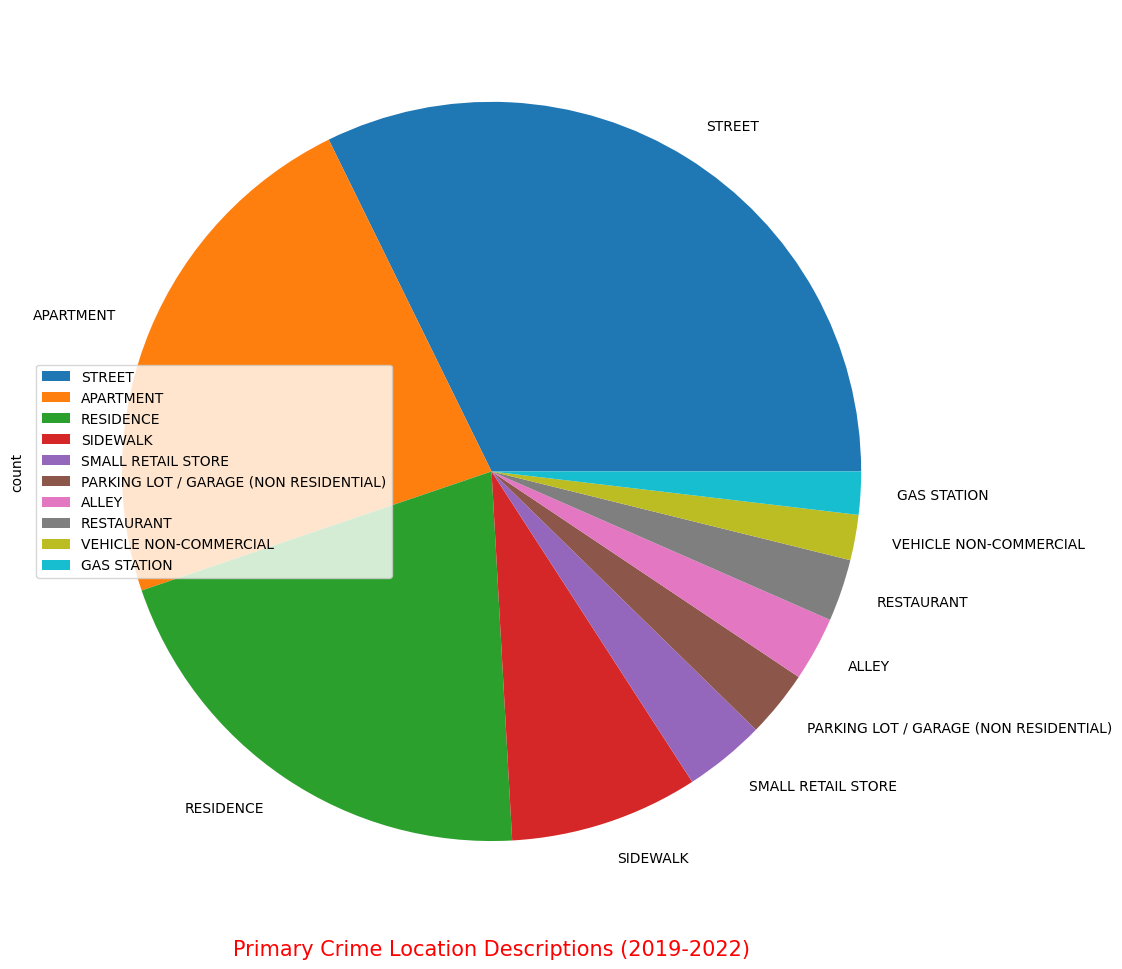

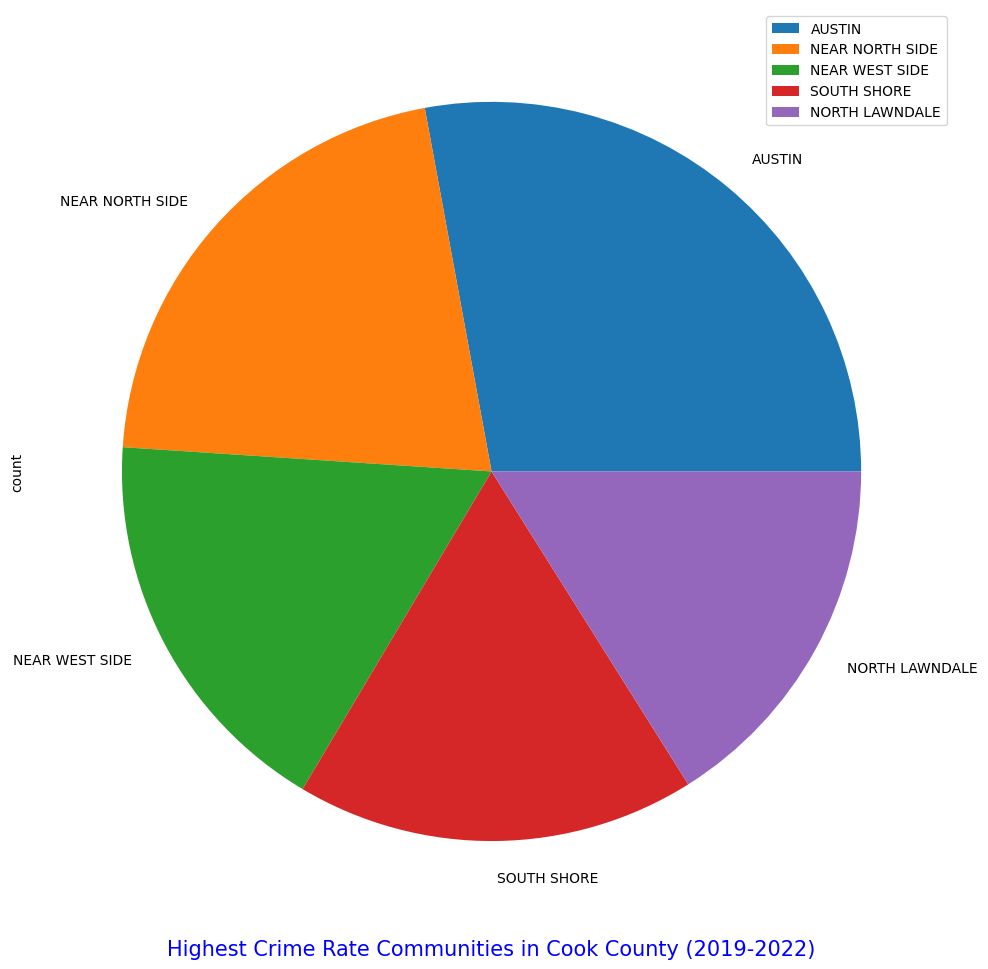

In [21]:
# pie chart distribution of top crime locations
primaryDF = temp['Location Description'].value_counts().head(10)
primaryDF.plot.pie(figsize=(15,12))
plt.xlabel('Primary Crime Location Descriptions (2019-2022)', fontsize=15, color='red')
plt.legend()
plt.show()

secondaryDF = temp['Community Name'].value_counts().head()
secondaryDF.plot.pie(figsize=(15,12))
plt.xlabel('Highest Crime Rate Communities in Cook County (2019-2022)', fontsize=15, color='blue')
plt.legend()
plt.show()

The community `Austin` seems to have the most reported cases of crime in Chicago, Illinois. However, it also seems as if there is a fair distribution of crimes occuring in the remaining four counties shown in the pie chart. We could likely infer that these communities have the highest crime occurences.

**Additionally** it is fair to also make an inference that the crimes within Chicago most frequently occur and are fairly distributed/found in areas of residence (single-unit housing, apartments) and the street. 

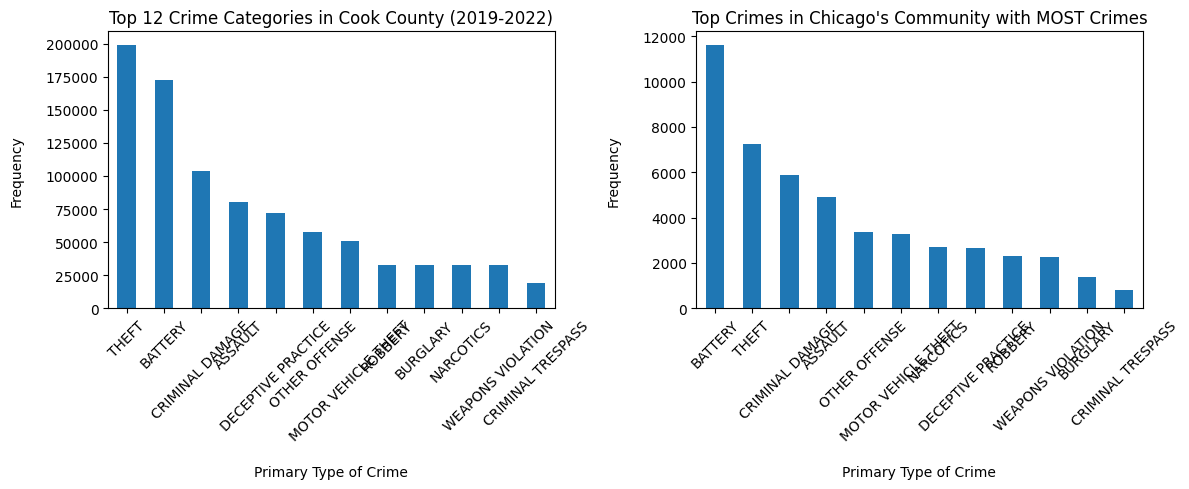

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5)) 

# First graph: Top 12 Crime Categories
df_time['Primary Type'].value_counts().head(12).plot.bar(ax=ax[0])
ax[0].set_title("Top 12 Crime Categories in Cook County (2019-2022)")
ax[0].set_xlabel("\nPrimary Type of Crime")
ax[0].set_ylabel("Frequency\n")
ax[0].tick_params(axis='x', rotation=45)  

# Second graph: Top Crime Categories in Community with most crimes
highest = df[df['Community Name'] == 'AUSTIN']
highest['Primary Type'].value_counts().head(12).plot.bar(ax=ax[1])
ax[1].set_title("Top Crimes in Chicago's Community with MOST Crimes")
ax[1].set_xlabel("\nPrimary Type of Crime")
ax[1].set_ylabel("Frequency\n")
ax[1].tick_params(axis='x', rotation=45) 

plt.tight_layout()  
plt.show()

We can clearly observe that crime categorized as `THEFT` has the highest occurences in Chicago, Cook County. The bar chart presents a  visual summarization of crime frequency distribution across distinct categories within Cook County (total of all districts). Notably, the taxonomy of crime reveals a pronounced prevalence of theft-related incidents, which conspicuously surpasses other categories, indicating it as the most exigent issue within the dataset. Following theft, the incidences of battery and criminal damage constitute the subsequent tiers of frequency, thereby suggesting a potential correlation between property crimes and violent offenses within this jurisdiction. The graphical representation delineates a right-skewed distribution of crime frequencies, with a steep decline observed as one progresses from the most to the least common offenses. This skewness could be reflective of the underlying social, economic, and environmental factors that disproportionately elevate certain crime rates. The lesser frequent categories, such as narcotics and criminal trespass, despite their position on the graph, still represent significant concerns and warrant focused analytical attention to understand their lower relative frequencies. Inter-category comparison shows a notable variance in frequency, which may invite a hypothesis that the underlying causes of these crimes have different rates of incidence or reporting within the community. The disparity in the magnitude of occurrences also raises inquiries into the effectiveness of law enforcement and preventative measures tailored to each crime category. Moreover, the visual data underscores the necessity for a multifaceted approach to crime prevention and resource allocation. Policymakers and law enforcement could leverage such a data-driven perspective to optimize strategies that address the most prevalent crimes, without neglecting the lower frequency but equally impactful crime types.

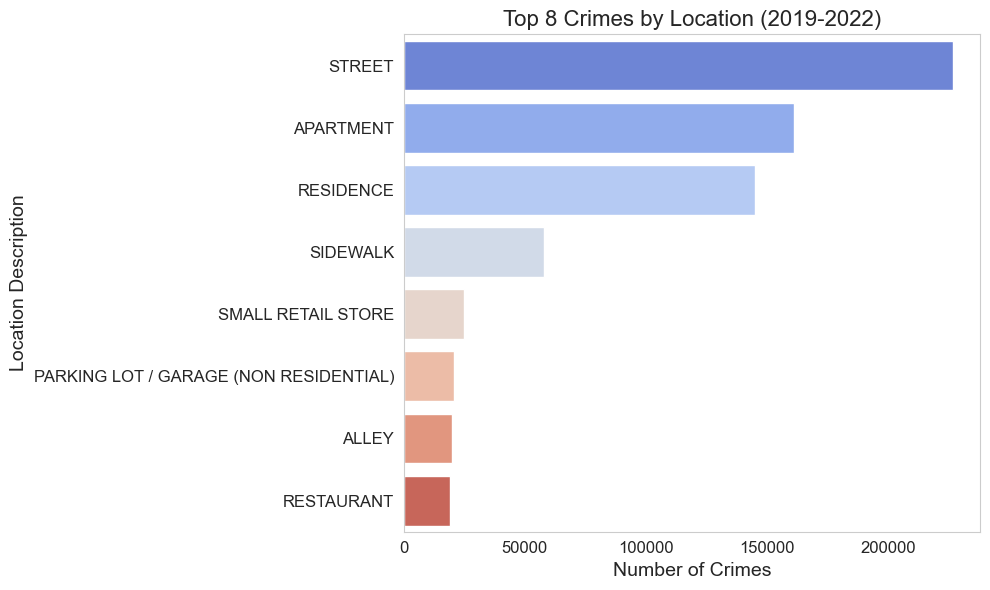

In [23]:
top_locations = df_time['Location Description'].value_counts().head(8)
sb.set_style("whitegrid")
plt.figure(figsize=(10, 6))
palette = sb.color_palette("coolwarm", len(top_locations))
sb.barplot(x=top_locations.values, y=top_locations.index, palette=palette)
# Customize the visualization
plt.title('Top 8 Crimes by Location (2019-2022)', fontsize=16)
plt.xlabel('Number of Crimes', fontsize=14)
plt.ylabel('Location Description', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='x')
plt.tight_layout()
plt.show()

Crimes are most frequently occuring in areas of residence within Chicago, Cook County. There could potentially be an observable correlation between crimes occuring within domestic cases, rather than by random occurence. Might look into investigating. 

In [24]:
def bar_plot(data, col):
    if data[col].dtype in ['object']:
        fig, ((axis1, axis2)) = plt.subplots(2, 1, figsize=(15,20))
        plot = df[['Arrest', col]].dropna()
        df1 = plot.loc[plot['Arrest'] == True]
        df2 = plot.loc[plot['Arrest'] == False]
        df1.groupby(col)[col].count().nlargest(10).plot(kind='barh', ax=axis1, title='Arrest: ' + col) 
        df2.groupby(col)[col].count().nlargest(10).plot(kind='barh', ax=axis2, title='NO Arrest: ' + col) 


In [25]:
def bar_plot(df, col, title_prefix=''):
    
    # CHECK TO SEE IF THE COLUMN IS PRESENT >> 
    if col in df.columns and df[col].dtype == 'object':
        plot_data = df[['Arrest', col]].dropna()
        sb.set_style("whitegrid")
        fig, axes = plt.subplots(2, 1, figsize=(10, 12))
        for i, arrest_status in enumerate([True, False]):
            temp_df = plot_data[plot_data['Arrest'] == arrest_status]
            count_series = temp_df[col].value_counts().nlargest(10)
            palette = sb.color_palette("rocket", len(count_series))
            sb.barplot(y=count_series.index, x=count_series.values, ax=axes[i], palette=palette)
            axes[i].set_title(f"{title_prefix}{'Yes Arrest' if arrest_status else 'No Arrest'}: {col}")
            axes[i].set_xlabel('Count')
            axes[i].set_ylabel(col)
        plt.tight_layout()
        plt.show()

    else:
        print(f"Column '{col}' is not present or not categorical.")


Location Descriptions: 



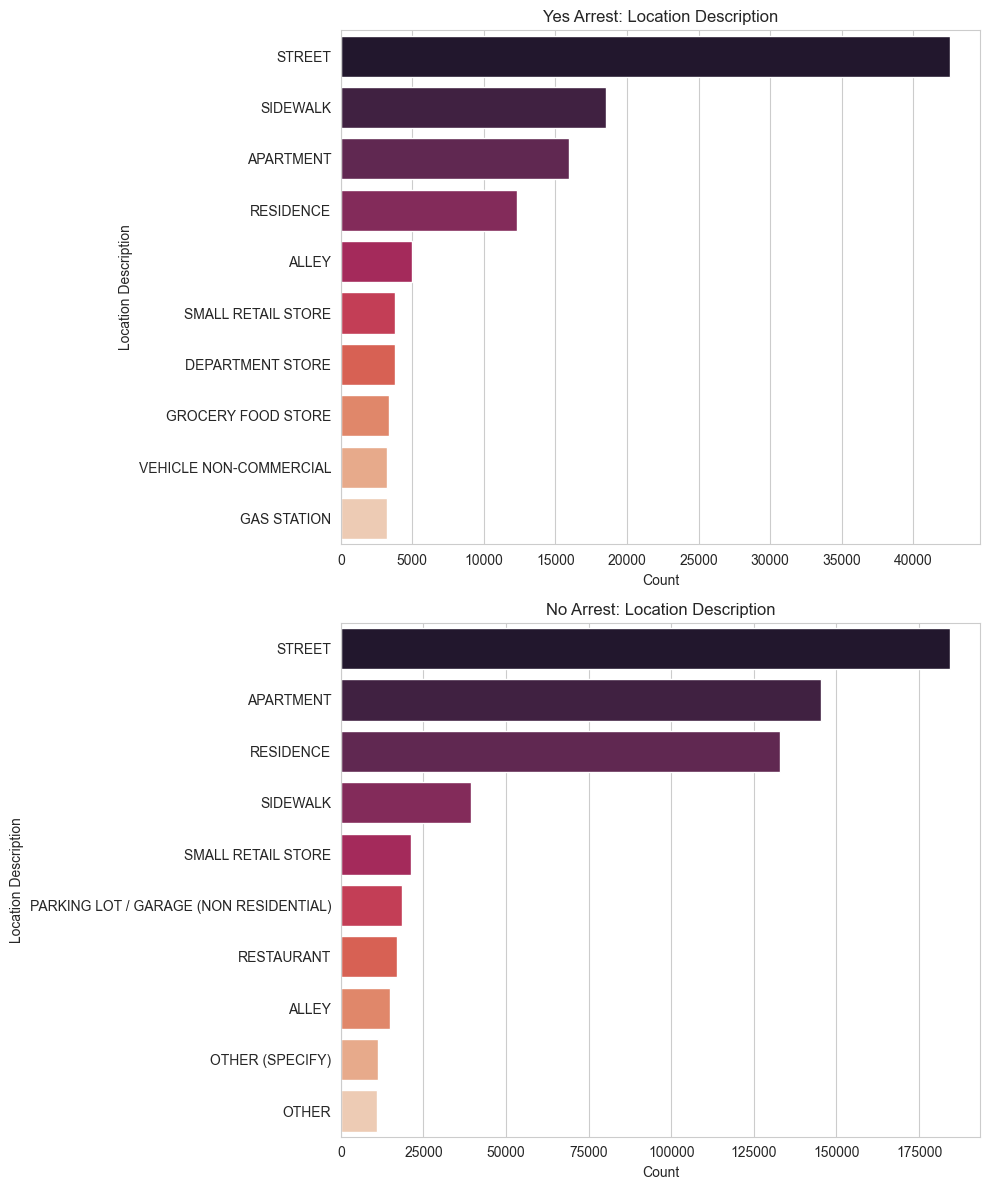

Primary Crime Types: 



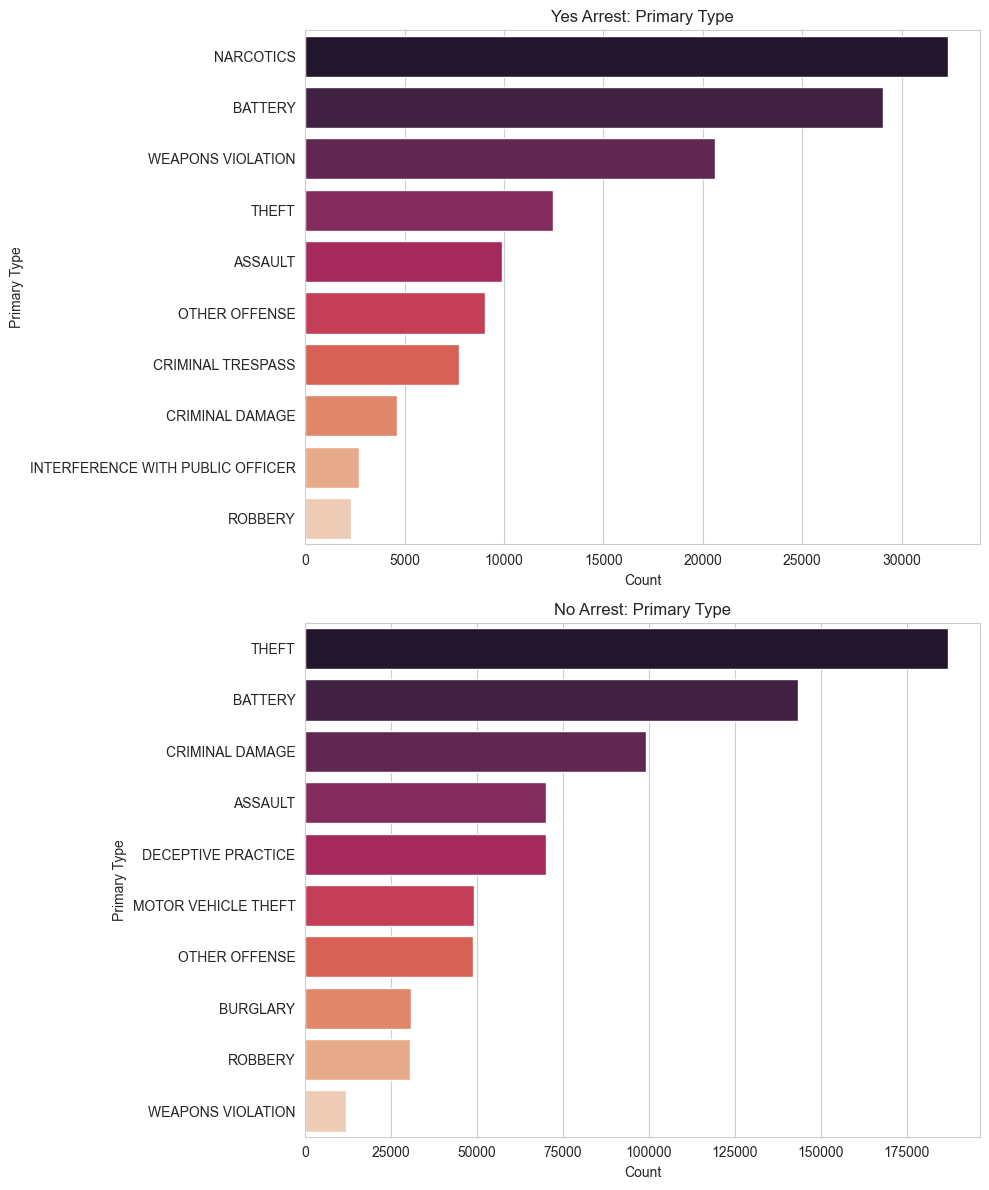

In [26]:
print("Location Descriptions: \n")
bar_plot(df_time, 'Location Description')
print("Primary Crime Types: \n")
bar_plot(df_time, 'Primary Type')

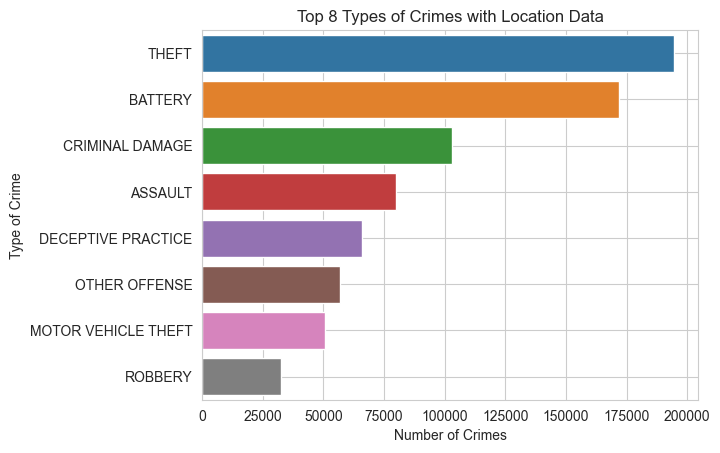

In [27]:
is_crimes = df_time[df_time["Location"].notnull()]
crime_counts = is_crimes.groupby("Primary Type").size().sort_values(ascending=False).head(8)
crime_counts_df = crime_counts.reset_index(name='Number of Crimes')
fig = sb.barplot(x="Number of Crimes", y="Primary Type", data=crime_counts_df)
plt.title("Top 8 Types of Crimes with Location Data")
plt.xlabel("Number of Crimes")
plt.ylabel("Type of Crime")
plt.grid(True)
plt.show()

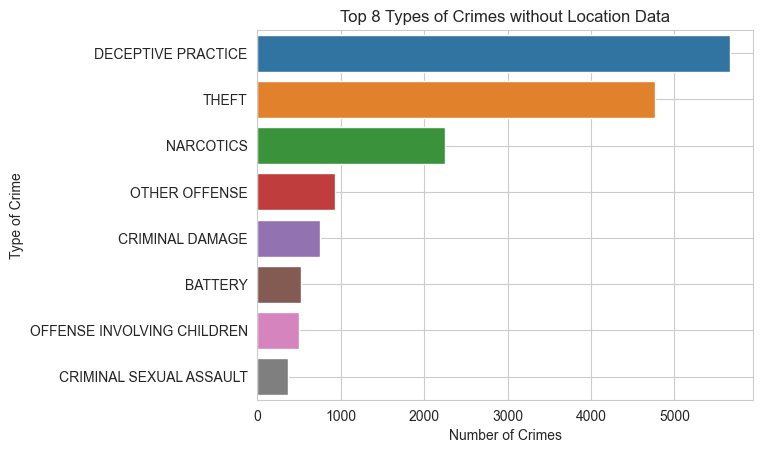

In [28]:
not_crime = df_time[df_time["Location"].isnull()]
crime_counts = not_crime.groupby("Primary Type").size().sort_values(ascending=False).head(8)
crime_counts_df = crime_counts.reset_index(name='Number of Crimes')
fig = sb.barplot(x="Number of Crimes", y="Primary Type", data=crime_counts_df)
plt.title("Top 8 Types of Crimes without Location Data")
plt.xlabel("Number of Crimes")
plt.ylabel("Type of Crime")
plt.grid(True)
plt.show()

* Deceptive Practice
It's the crime where a person commits a practice when they have the intent to defraud another person and does any of the follow:
- Knowingly cause another person, by threat or deception, to execute a document/payment
- Dispose the victim of a property or incur a pecuniary oblogation
> This in turn makes sense, that it wouldn't have a location, given that most of these crimes are reported through online documentation, an idea would be that the crime occurs in wards with an higher overall income, who may be more suspect to being targeted by these fraudulent malpractices. 

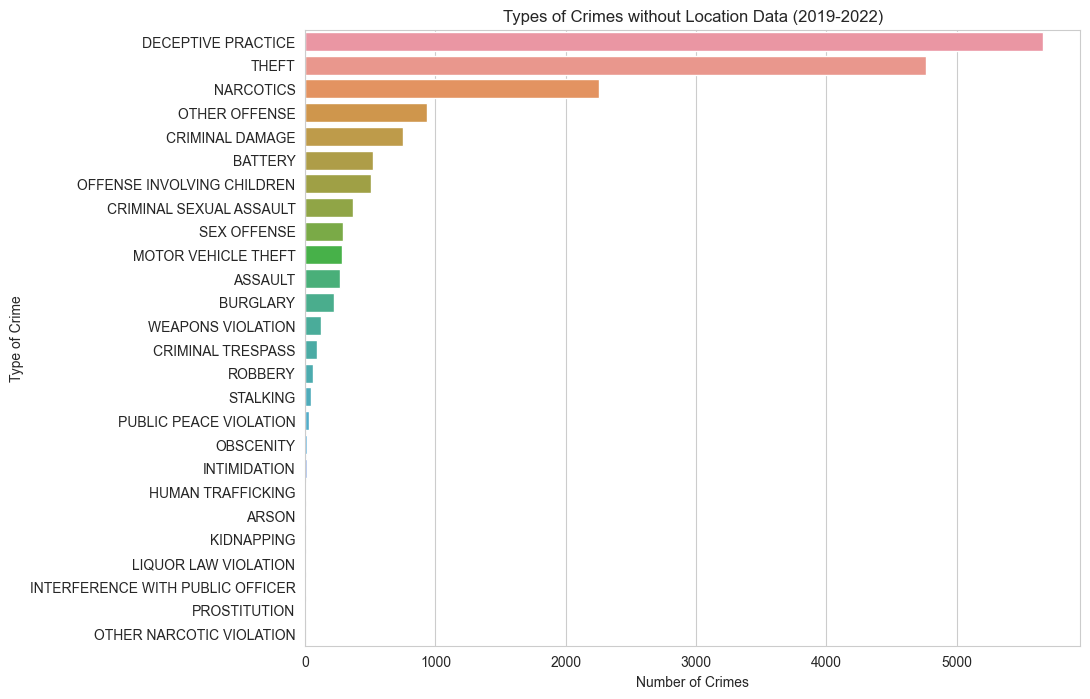

In [29]:
not_crime = df_time[df_time["Location"].isnull()==True]
not_crime = not_crime.groupby("Primary Type").size().sort_values(ascending=False).reset_index(name='counts')
fig, ax = plt.subplots(figsize=(10, 8))  # Adjust the figure size as needed
sb.barplot(data=not_crime, y="Primary Type", x="counts", ax=ax)
plt.title("Types of Crimes without Location Data (2019-2022)")
plt.xlabel("Number of Crimes")
plt.ylabel("Type of Crime")
plt.show()

### 2.2 Looking into Narcotics Crimes
Based on the previous exploration of data, we found some interesting points regarding Narcotics arrests specifically, where those crimes had the most `arrest` per case. Based on that, we wanted to look into which community area of Chicago has the most Narcotics crime arrests and make some potential further inferences into it. 

### 2.3 Time Based Analysis
Look into our `time_df` dataset, which has been converted under the pandas date-time index. With this we can look into trends, potentially construct an ARIMA model which is great for computing data with a "seasonality" trend, in this case, there could be a potential of it given that we expect this crime's dataset to be very fluctuating in the grandscope of a year, etc. 

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
[2302, 1263, 1325, 1480, 1352, 1026, 975, 1111, 1323, 1316, 1244, 1163, 1677, 1250, 1478, 1551, 1488, 1555, 1449, 1279, 1277, 1219, 1379, 1170]


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is n

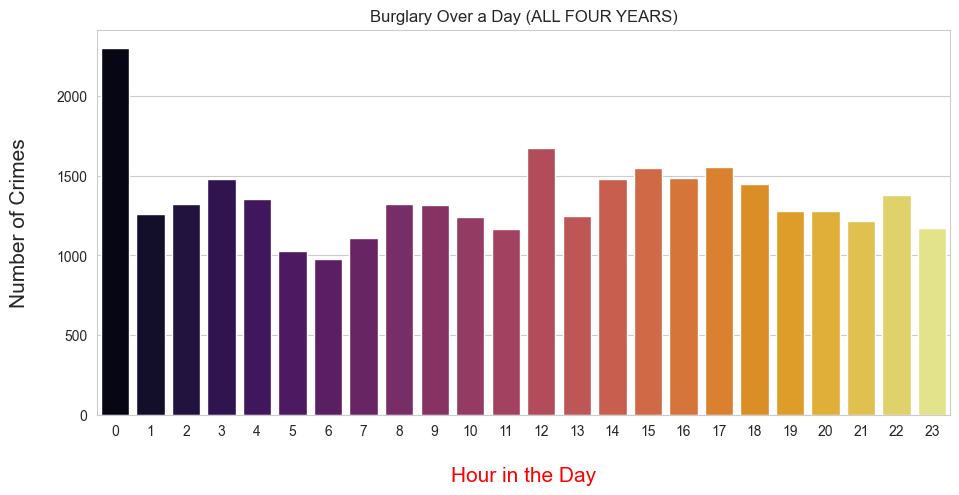

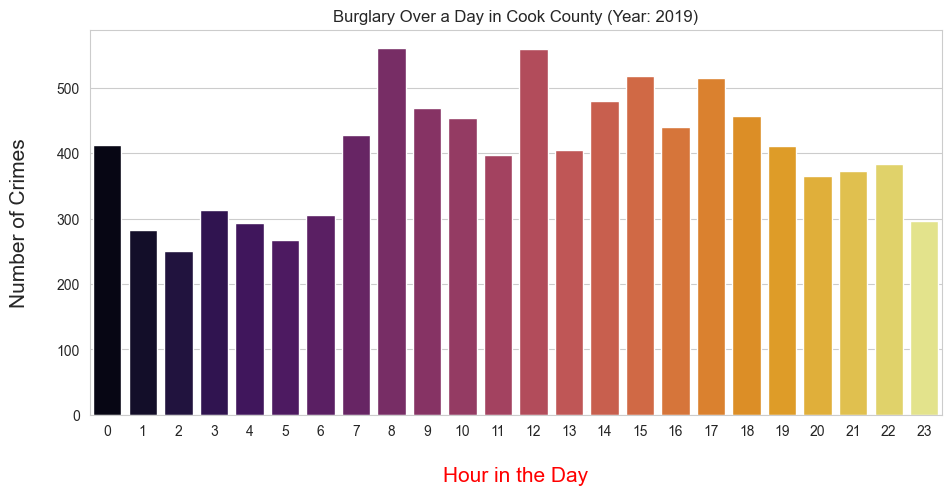

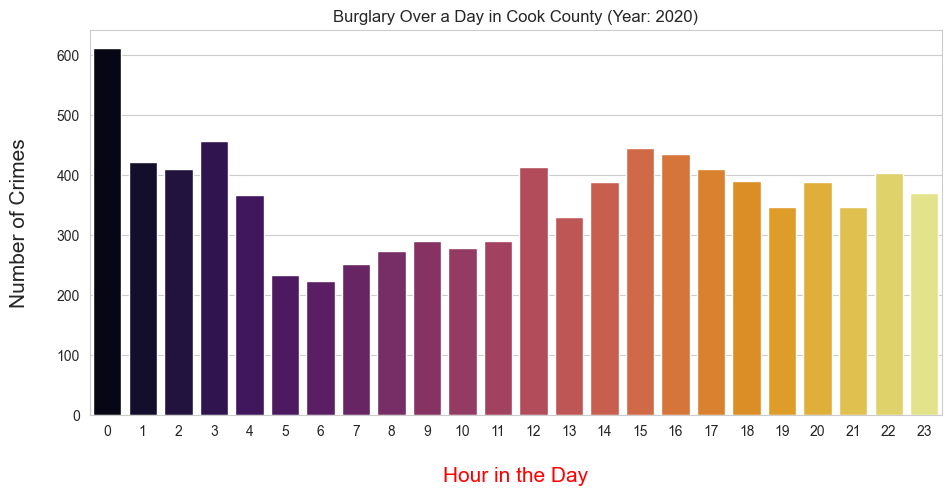

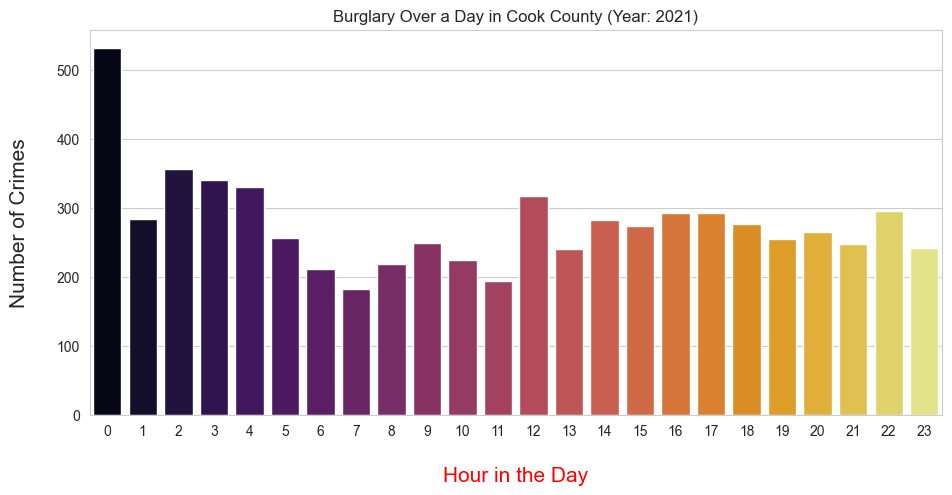

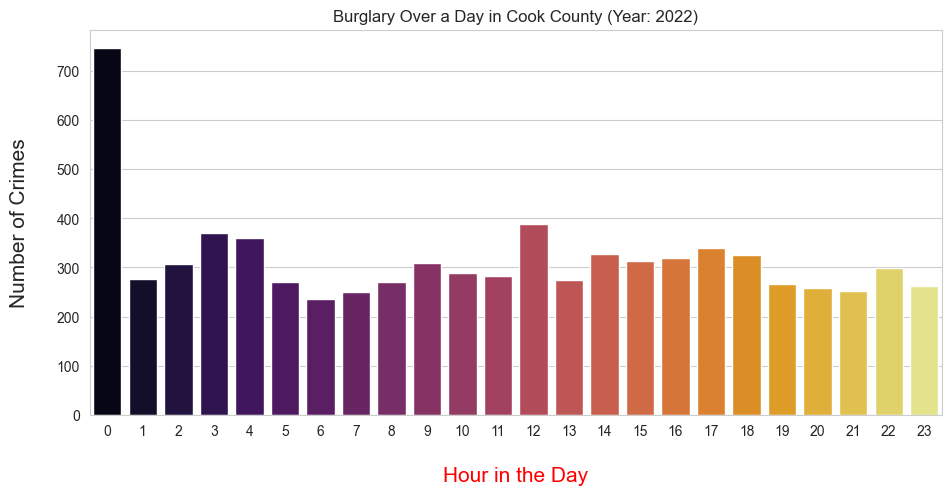

In [30]:
burglary = df_time[df_time['Primary Type'] == 'BURGLARY']
#df_time['HourOfDay']
hours = [int(x) for x in list(burglary['HourOfDay'].unique())]
hours = sorted(hours)
print(hours)

burglary_crimes = list(burglary['HourOfDay'].value_counts().sort_index())
print(f"{burglary_crimes}")

# 
fig, ax = plt.subplots(figsize=(11,5))
sb.barplot(x=hours, y=burglary_crimes, palette="inferno")
plt.title("Burglary Over a Day (ALL FOUR YEARS)")
plt.xlabel("\nHour in the Day", fontdict={'fontsize': 15}, color='red')
plt.ylabel("Number of Crimes\n", fontdict={'fontsize': 15})

def queue_initial(parse):
    queue = []
    for year in df_time[parse].unique():
        queue.append(year)
    return queue

def burglary_by_year():
    #pass in a base df
    queue = queue_initial("Year")
    for parsed in queue:
        sub = df_time[df_time['Year'] == parsed]
        sub = sub[sub['Primary Type'] == 'BURGLARY']
        hours = sorted([int(x) for x in list(sub['HourOfDay'].unique())])
        # attributes for crime frequency
        nominal_sub = list(sub['HourOfDay'].value_counts().sort_index())
        fig, ax = plt.subplots(figsize=(11, 5))
        sb.barplot(x=hours, y=nominal_sub, palette='inferno')
        plt.title(f"Burglary Over a Day in Cook County (Year: {parsed})")
        plt.xlabel("\nHour in the Day", fontdict={'fontsize': 15}, color='red')
        plt.ylabel("Number of Crimes\n", fontdict={'fontsize': 15})

burglary_by_year()


ARIMA (Auto-Regressive Integrated Moving Average) is a general class of statistical models for time series analysis forecasting. ARIMA uses time series' past values and/or forecast errors to predict values. 

Example: ARIMA model assumption is stationary: the time series has its statistical properties remain constant across TIME.

Params: Three components/parameters: AR + I + Moving Average (MA) (p, d, q)
https://www.youtube.com/watch?v=-aCF0_wfVwY&t=1096s

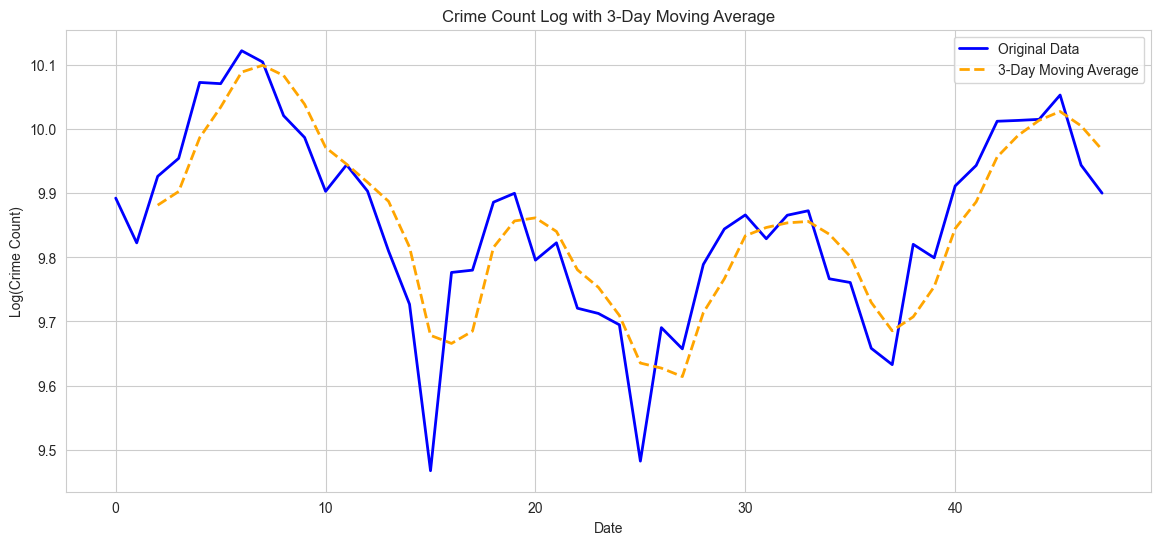

In [31]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
# ARIMA time-series forecasting 
#df_time.info()
dataframe = df_time.groupby('MonthYear').size().reset_index(name='Crime Count')
#dataframe.plot()
logCrime = np.log(dataframe['Crime Count'])
# 3 day estimate moving average
logCrimeRolling = np.log(dataframe['Crime Count'].rolling(window=3).mean())

plt.figure(figsize=(14, 6))
plt.plot(logCrime, label='Original Data', color='blue', linestyle='-', linewidth=2)
plt.plot(logCrimeRolling, label='3-Day Moving Average', color='orange', linestyle='--', linewidth=2)
plt.title('Crime Count Log with 3-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Log(Crime Count)')
plt.legend()
plt.grid(True)
plt.show()

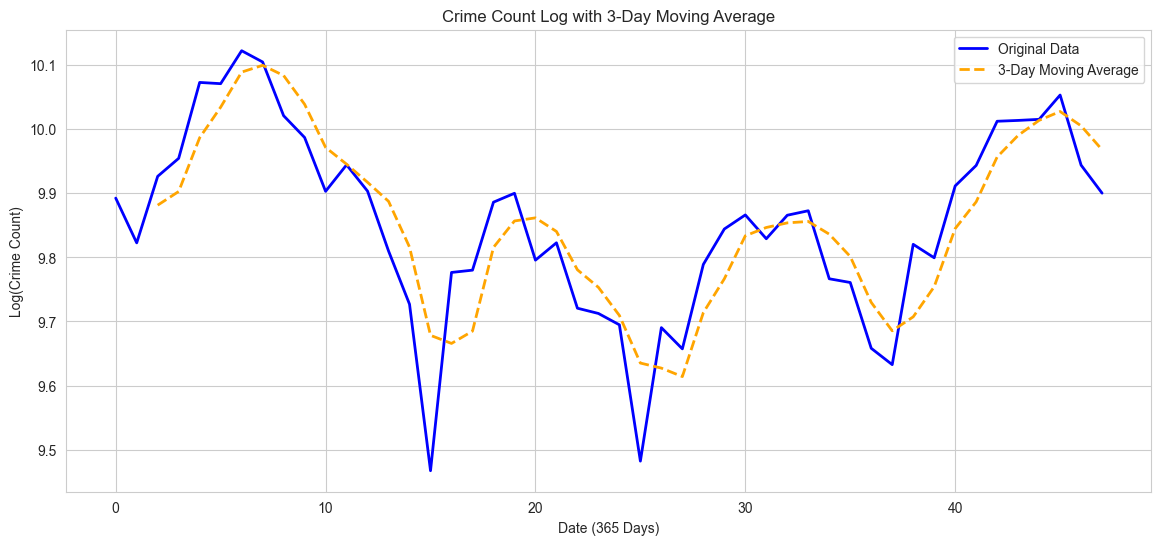

Exploring a specific year of 2019


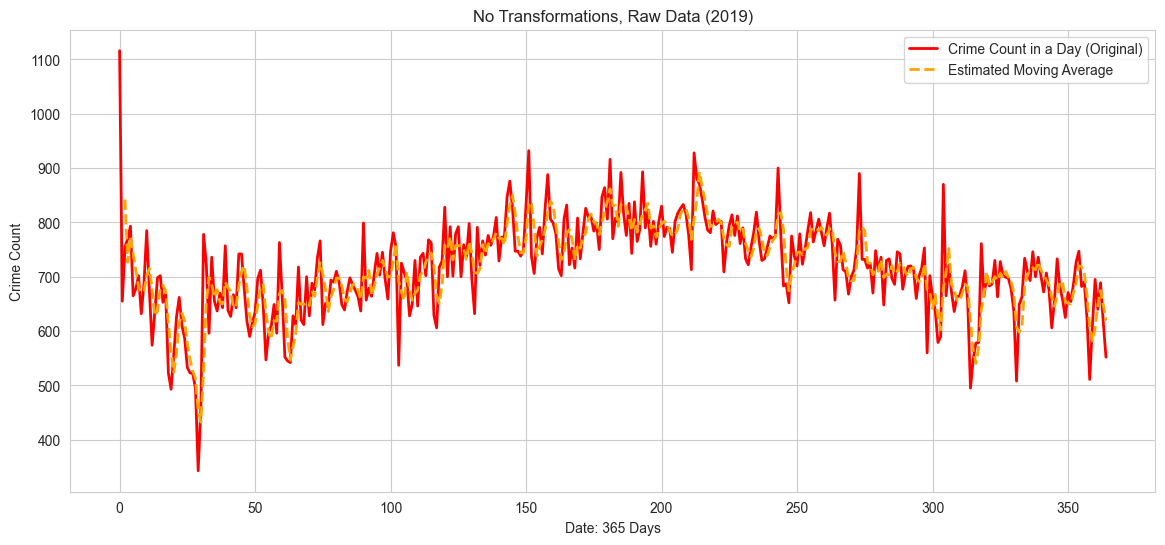

In [32]:
dataframe2019 = df_time[df_time['Year'] == 2019]
dataframe2019 = dataframe2019.groupby('DayOfYear').size().reset_index(name='Crime Count')
logcrimes19 = np.log(dataframe2019['Crime Count'])
logCrimeRolling19 = np.log(dataframe2019['Crime Count'].rolling(window=3).mean())

plt.figure(figsize=(14, 6))
plt.plot(logCrime, label='Original Data', color='blue', linestyle='-', linewidth=2)
plt.plot(logCrimeRolling, label='3-Day Moving Average', color='orange', linestyle='--', linewidth=2)
plt.title('Crime Count Log with 3-Day Moving Average')
plt.xlabel('Date (365 Days)')
plt.ylabel('Log(Crime Count)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Exploring a specific year of {df['Year'].min()}")
crimes19 = (dataframe2019['Crime Count'])
rolling19 = (dataframe2019['Crime Count'].rolling(window=3).mean())
plt.figure(figsize=(14,6))
plt.plot(crimes19, label='Crime Count in a Day (Original)', color='red', linestyle='-', linewidth=2)
plt.plot(rolling19, label='Estimated Moving Average', color='orange', linestyle='--', linewidth=2)
plt.title("No Transformations, Raw Data (2019)")
plt.xlabel('Date: 365 Days')
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)
plt.show()

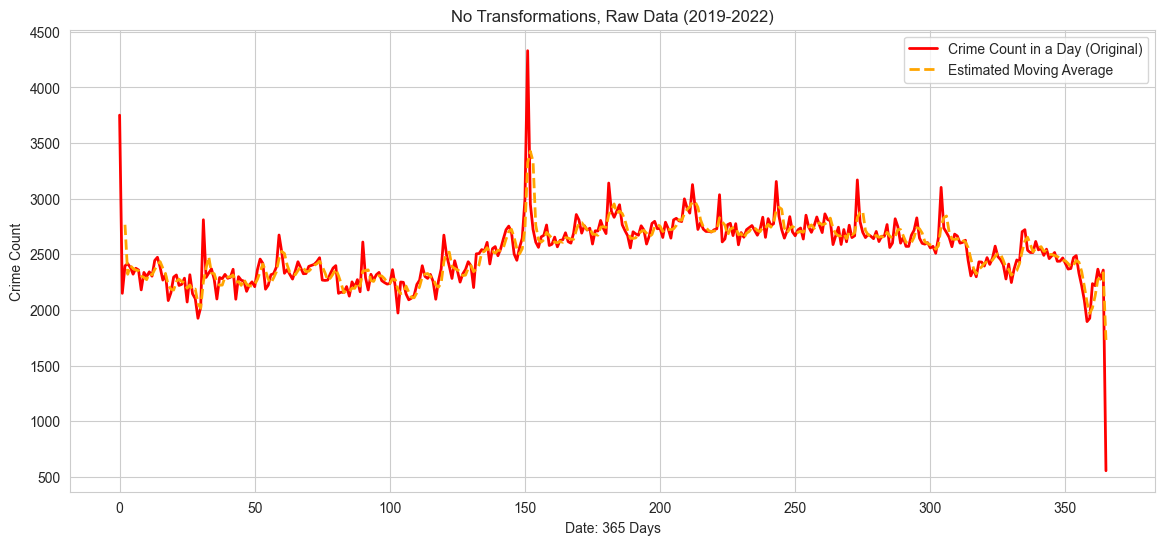

Skew Coefficient for Log-Transformation is 0.15966381190361428
Likewise, for a reciprocal transformation it is: 0.4572275438516546
Finally, URP535 rocks and a sqare root skew coefficient is 0.0157064379412421

------------------------------------------------------------------------------
Baseline Skew is (0.005177657787409347, 0.1311120877507417)


In [33]:
dataframe2 = df_time.groupby('DayOfYear').size().reset_index(name='Crime Count')
all = (dataframe2['Crime Count'])
rolling_all = (dataframe2['Crime Count'].rolling(window=3).mean())
log_all = np.log(dataframe2['Crime Count'].rolling(window=3).mean())
recip_all = 1 / (dataframe2['Crime Count'].rolling(window=3).mean())
sqrt_all = np.sqrt((dataframe2['Crime Count'].rolling(window=3).mean()))

plt.figure(figsize=(14,6))
plt.plot(all, label='Crime Count in a Day (Original)', color='red', linestyle='-', linewidth=2)
plt.plot(rolling_all, label='Estimated Moving Average', color='orange', linestyle='--', linewidth=2)
plt.title("No Transformations, Raw Data (2019-2022)")
plt.xlabel('Date: 365 Days')
plt.ylabel("Crime Count")
plt.legend()
plt.grid(True)
plt.show()

print(f"Skew Coefficient for Log-Transformation is {abs(log_all.skew())}")
print(f"Likewise, for a reciprocal transformation it is: {abs(recip_all.skew())}")
print(f"Finally, URP535 rocks and a sqare root skew coefficient is {abs(sqrt_all.skew())}\n")
print("------------------------------------------------------------------------------")
print(f'Baseline Skew is {abs(all.skew()), abs(rolling_all.skew())}')



When examining the skew coefficient emerging from our year-long time-series dataset, it becomes clear that the pronounced variability among smaller values warrants attention. Interestingly, our dataset does not appear to be significantly skewed by outliers, a factor which typically necessitates caution. Instead, it is the application of transformations—such as logarithmic or reciprocal—that brings the variability into focus. These transformations alter the relative spacing between data points, thereby intensifying the skewness. This insight informs our analytical approach, highlighting the need for careful selection of data transformation methods to accurately interpret the dataset's trends.

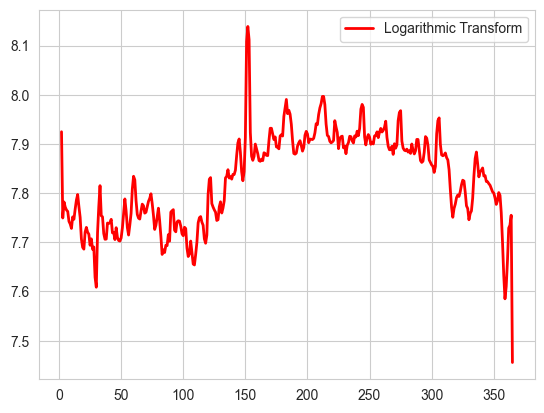

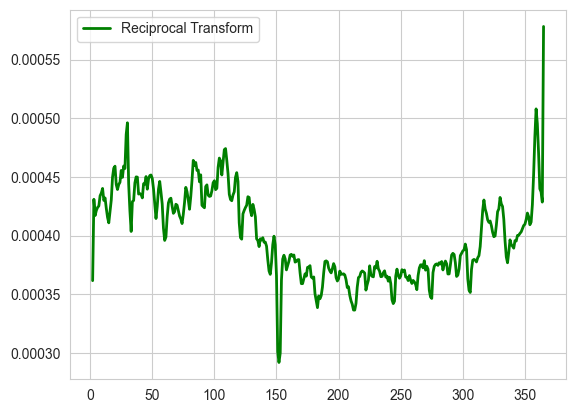

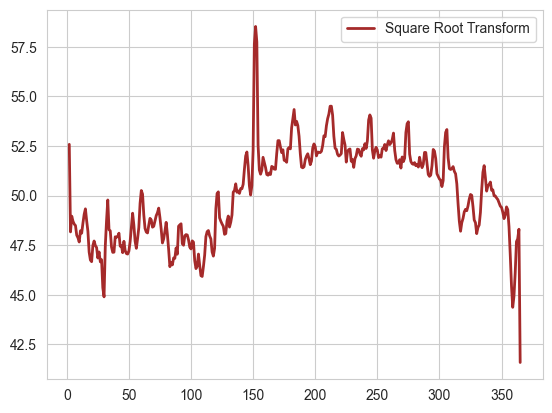

In [34]:
plt.plot(log_all, label='Logarithmic Transform', color='red', linestyle='-', linewidth=2)
plt.legend()
plt.grid(True)
plt.show()

plt.plot(recip_all, label='Reciprocal Transform', color='green', linestyle='-', linewidth=2)
plt.legend()
plt.grid(True)
plt.show()

plt.plot(sqrt_all, label='Square Root Transform', color='brown', linestyle='-', linewidth=2)
plt.legend()
plt.grid(True)
plt.show()

To further our process of the ARIMA model for crime, we decided to move forward with the `Crimes-Per-Day` metric, spanning across all four-years of our interest. In order to look into this, we had to use a lot of outside resources to learn how to actually set up this process, since it was an interest/topic that we wanted to explore beyond the course material regarding urban informatics. 

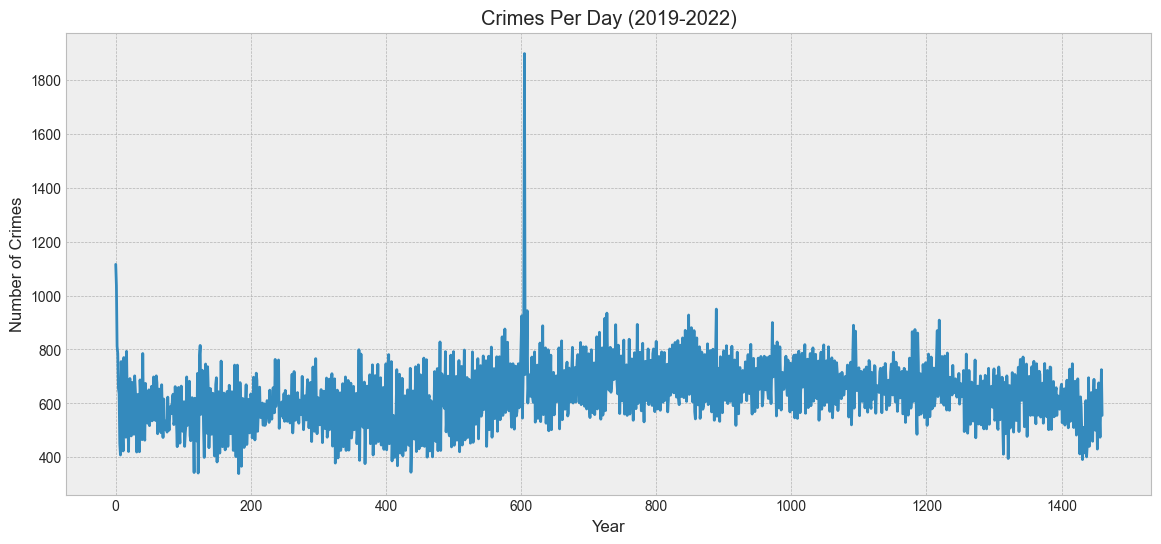

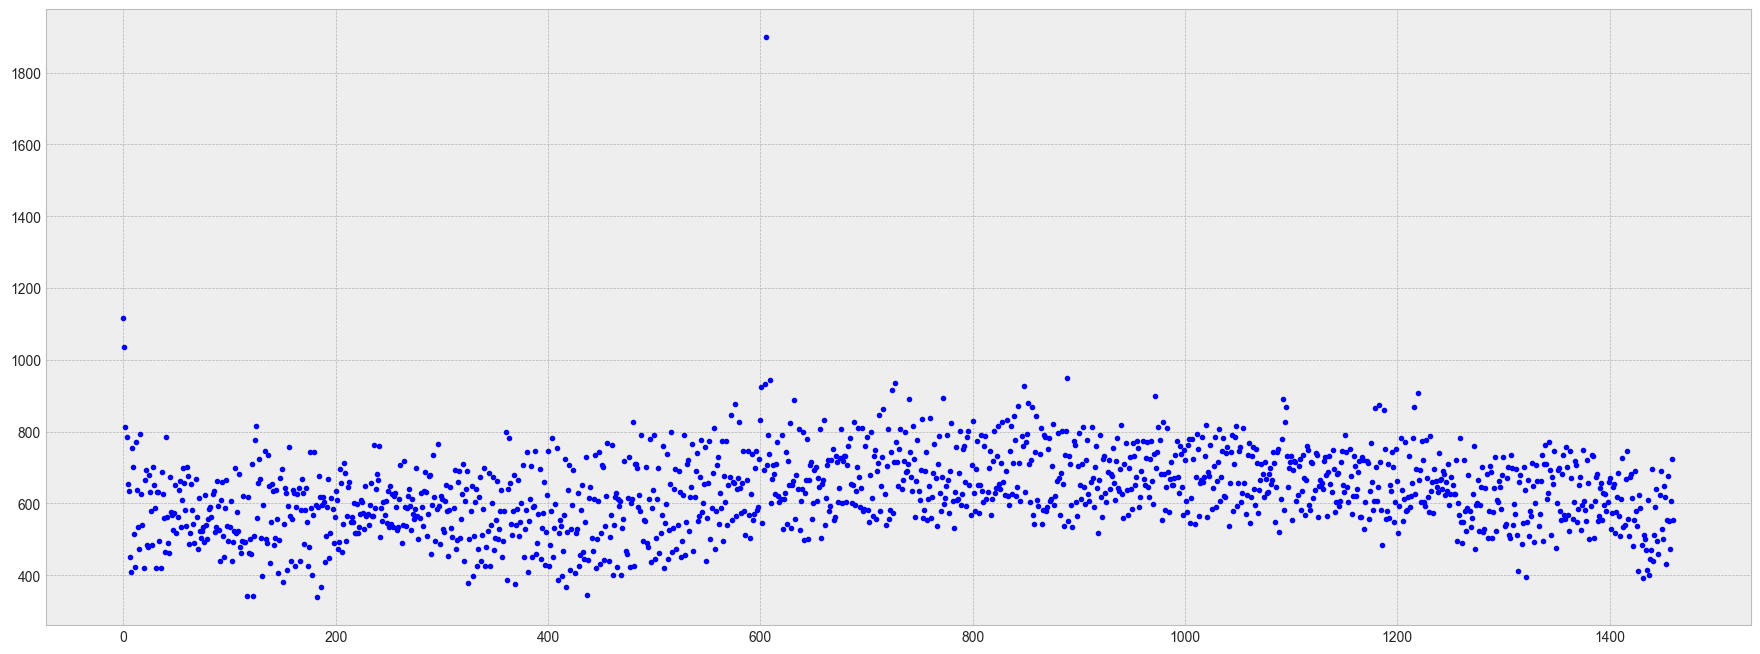

In [35]:
arima_df = df_time.groupby('DayYear').size().reset_index(name='Crime Count')
plt.style.use('bmh')
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(arima_df['Crime Count'])
plt.title('Crimes Per Day (2019-2022)')
plt.xlabel('Year')
plt.ylabel('Number of Crimes')
plt.show()
#plt.savefig('visualizations/orig_time_data.png', bbox_inches = "tight", pad_inches=.5)

arima_df['Crime Count'].plot(figsize = (22,8), style = 'b.')
plt.show()

In [36]:
from statsmodels.tsa.stattools import adfuller
test = adfuller(arima_df['Crime Count'])
dfoutput = pd.Series(test[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])
print(dfoutput)

Test Statistic                   -2.540640
p-value                           0.105897
# of Lags Used                   23.000000
Number of Observations Used    1437.000000
dtype: float64


Fail to reject our null-hypothesis, based on this adfuller test data, our p-value is above 0.05, meaning that the original data is NOT stationary.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


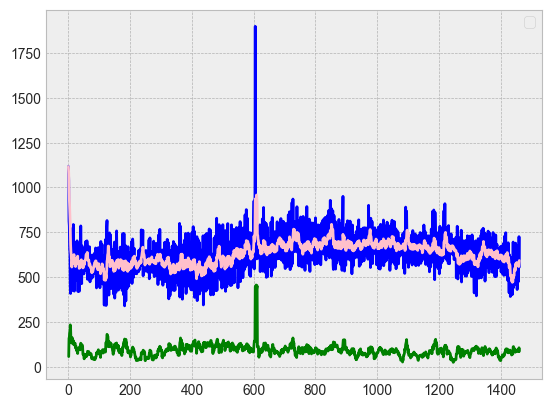

0    1116.000000
1    1076.500000
2     988.333333
Name: Crime Count, dtype: float64

In [37]:
roll_mean = arima_df['Crime Count'].rolling(window=7, min_periods=1).mean()
roll_std = arima_df['Crime Count'].rolling(window=7, min_periods=1).std()

plt.plot(arima_df['Crime Count'], color = 'blue')
plt.plot(roll_mean, color = 'pink')
plt.plot(roll_std, color = 'green')
plt.legend()
plt.show()

roll_mean.head(3)

Below On: ARIMA Model
Predict our own time-series with the ARIMA Modeling technique, data science concept.
What is ARIMA?
- ARIMA (Auto-Regressive Integrated Moving Average) is a general class of statistical models for time series analysis forecasting.
- ARIMA uses a time series' past values and/or forecast errors to predict its future values
- ARIMA model assumption - **stationary**: the time series has its statistical properties remain constant across time.
- THREE COMPONENTS: `AR + I + MA (p,d,q)`

---
~ **AR** (`Auto-Regressive`): the time series is linearly regressed on its own past values.

~ **I** (`Integrated`): if not stationary, the time series can be differenced to become stationary, i.e., compute the difference between the consecutive observations.

~ **MA** (`Moving Average`): the time series is 'regressed' on the past forecast errors.


Help Resource: `https://www.youtube.com/watch?v=-aCF0_wfVwY`

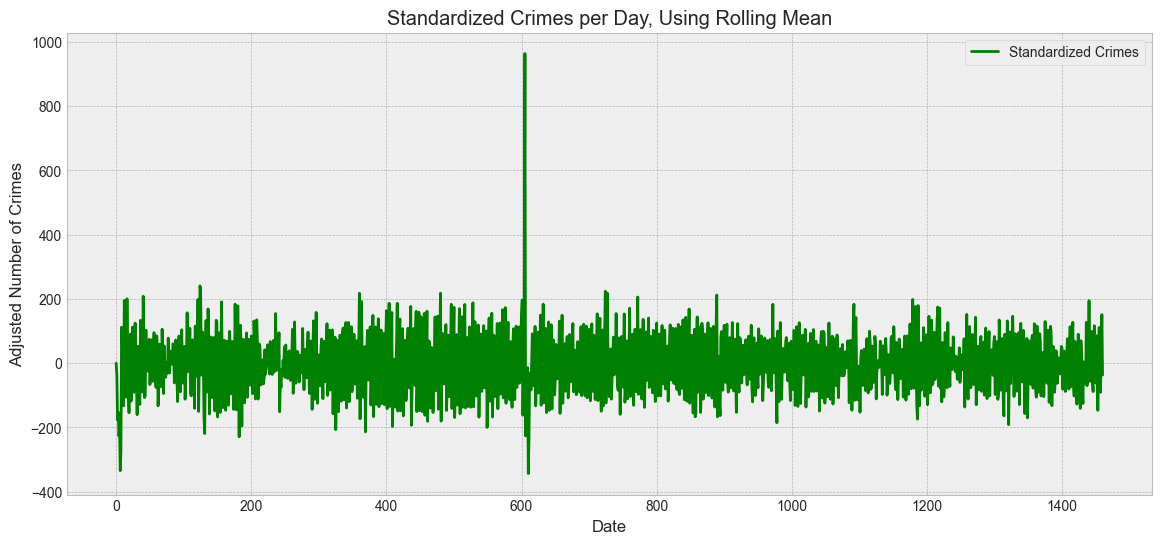

Test Statistic                -1.271141e+01
p-value                        1.028239e-23
# of Lags Used                 2.200000e+01
Number of Observations Used    1.438000e+03
dtype: float64


In [49]:
"""ARIMA Model in Python for Time-Series Forecasting"""
standardization = arima_df['Crime Count'] - roll_mean
standardization.head(3)

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(standardization, color='green', label='Standardized Crimes')
ax.set_title('Standardized Crimes per Day, Using Rolling Mean')
ax.set_xlabel('Date')
ax.set_ylabel('Adjusted Number of Crimes')
plt.legend()
plt.grid(True)
plt.show()

test = adfuller(standardization)
output = pd.Series(test[0:4], index=['Test Statistic','p-value','# of Lags Used','Number of Observations Used'])
print(output)

Based on these results, particularly the super low p-value and the very negative test statistic, it looks like the `rolling mean transformation` helped make the series stable (or stationary). However, we should keep in mind that making a time series stable by using transformations like the rolling mean can sometimes hide the real behavior of the data. This method smooths out the data, which might change or remove important patterns in the original data that you might need for further analysis or predictions.

ROLLING MEAN TRANSFORMATION


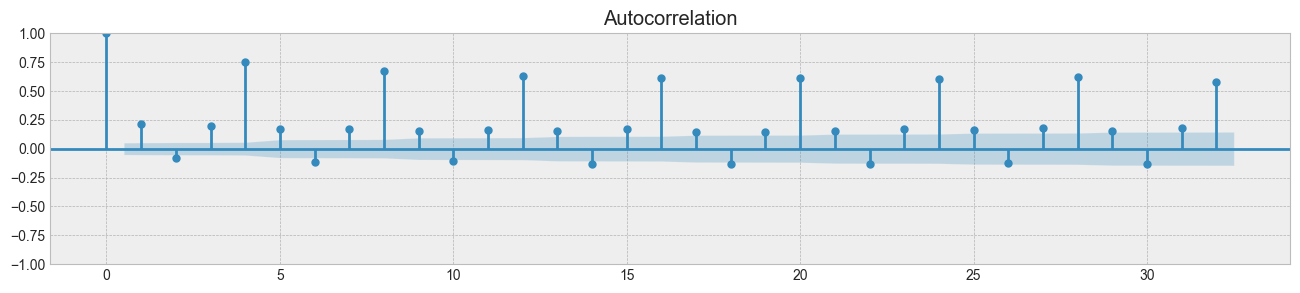

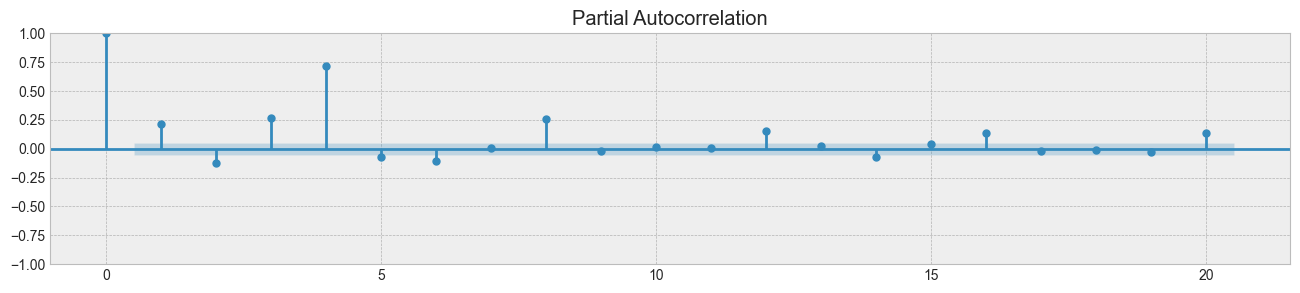

In [50]:
print("ROLLING MEAN TRANSFORMATION")
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(arima_df['Crime Count'], alpha=.05, ax=ax)
fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(arima_df['Crime Count'], alpha=.05, lags=20, ax=ax)
plt.show()

LOG TRANSFORMATION


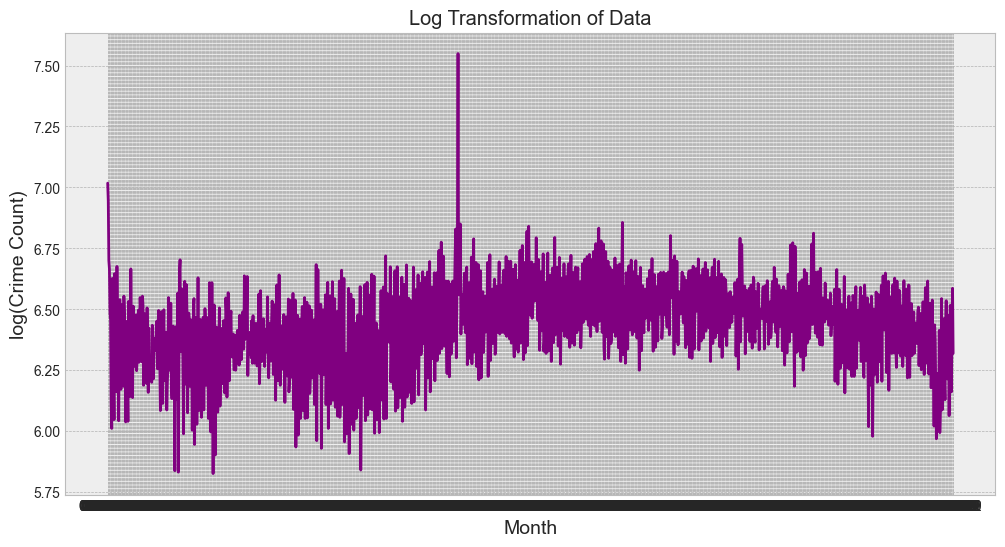

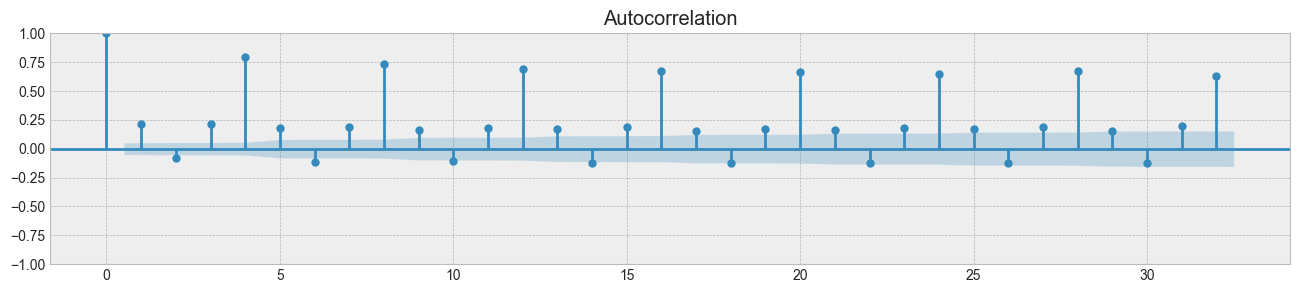

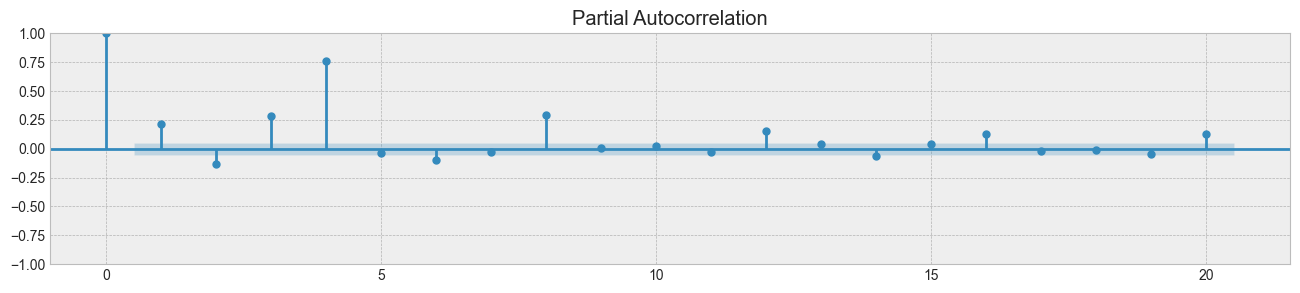

In [60]:
arima_df = arima_df.set_index('DayYear')
index = arima_df.index
log_data = pd.Series(np.log(arima_df['Crime Count']), index=index)
fig = plt.figure(figsize=(12,6))
plt.plot(log_data, color='purple')
plt.xlabel('Month', fontsize=14)
plt.ylabel('log(Crime Count)', fontsize=14)
plt.title('Log Transformation of Data')

# PACF and ACF Stationary Check, Compute which transformation is more appropriate.
print("LOG TRANSFORMATION")
fig, ax = plt.subplots(figsize=(16,3))
plot_acf(log_data, alpha=.05, ax=ax)
fig, ax = plt.subplots(figsize=(16,3))
plot_pacf(log_data, alpha=.05, lags=20, ax=ax)
plt.show()

# make our log_transformation data into a DataFrame
log_data = log_data.to_frame()

In [75]:
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA

X = log_data.index
y = log_data['Crime Count']
train_set = log_data.loc['001-2019' : '365-2021']
test_set = log_data.loc['001-2022':'365-2022']
X_train, X_test = train_set.index, test_set.index
y_train, y_test = train_set['Crime Count'], test_set['Crime Count']

baseline_model = AutoReg(y_train, lags=4)
output = baseline_model.fit()
print(output.summary())

                            AutoReg Model Results                             
Dep. Variable:            Crime Count   No. Observations:                 1459
Model:                     AutoReg(4)   Log Likelihood                1233.637
Method:               Conditional MLE   S.D. of innovations              0.104
Date:                Thu, 25 Apr 2024   AIC                          -2455.275
Time:                        21:01:48   BIC                          -2423.578
Sample:                             4   HQIC                         -2443.449
                                 1459                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              1.0859      0.174      6.236      0.000       0.745       1.427
Crime Count.L1     0.0522      0.017      3.100      0.002       0.019       0.085
Crime Count.L2    -0.0514      0.017

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [79]:
arima_model = ARIMA(y_train, order=(10,0,0))
model_fit = arima_model.fit()
print(model_fit.summary())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:559: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  _index = to_datetime(index)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/

                               SARIMAX Results                                
Dep. Variable:            Crime Count   No. Observations:                 1459
Model:                ARIMA(10, 0, 0)   Log Likelihood                1292.116
Date:                Thu, 25 Apr 2024   AIC                          -2560.232
Time:                        21:02:27   BIC                          -2496.806
Sample:                             0   HQIC                         -2536.570
                               - 1459                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          6.4368      0.021    311.049      0.000       6.396       6.477
ar.L1          0.0875      0.022      4.012      0.000       0.045       0.130
ar.L2          0.0537      0.022      2.405      0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### 3.1 Predictive Modeling in the Urban Context
Using sklearn's built in models, preprocessing tools, and metric outputs, let's explore some variables of interest in this dataset. Obviously the dataset is `imbalanced` like mentioned earlier, we must do something to make a standardization of this.

In [83]:
# install required packages for further modeling
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix

In [82]:
labelEncoder = LabelEncoder()
primaryEncoded = labelEncoder.fit_transform(df['Primary Type'])
primaryEncoded
df['Primary Type Encoded'] = primaryEncoded

labelEncoder2 = LabelEncoder()
locationEncoded = labelEncoder2.fit_transform(df['Location Description'])
df['Location Description Encoded'] = locationEncoded

# let us create an instance of label encoder for other categorical variables
labelEncoder3 = LabelEncoder()
blockEncoded = labelEncoder3.fit_transform(df['Block'])
df['Block Encoded'] = blockEncoded

NameError: name 'LabelEncoder' is not defined

In [62]:
from sklearn.decomposition import PCA 
# PCA will help us to combine some features
location = df[['Latitude', 'Longitude']]
pca = PCA(n_components=1, random_state=123)
loc = pca.fit_transform(location)
df['Location PCA'] = loc
df.head(3)

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,Community Name,Walk,Scaled_Walk,geometry,Primary Type Encoded,Location Description Encoded,Block Encoded,Location PCA
0,24368,JC103046,01/03/2019 02:37:00 PM,050XX S INDIANA AVE,0110,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,224,2,3.0,38.0,01A,1178455.0,1871575.0,2019,09/01/2022 03:42:17 PM,41.802909,-87.621048,"(41.802908524, -87.62104831)",GRAND BOULEVARD,400.718503,0.396666,POINT (1178455 1871575),11,21,21586,-0.057867
1,24369,JC103046,01/03/2019 02:37:00 PM,050XX S INDIANA AVE,0110,HOMICIDE,FIRST DEGREE MURDER,AUTO,False,False,224,2,3.0,38.0,01A,1178455.0,1871575.0,2019,09/01/2022 03:42:17 PM,41.802909,-87.621048,"(41.802908524, -87.62104831)",GRAND BOULEVARD,400.718503,0.396666,POINT (1178455 1871575),11,21,21586,-0.057867
2,24370,JC105864,01/05/2019 04:23:00 PM,012XX N ADA ST,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,True,False,1433,14,2.0,24.0,01A,1167119.0,1908611.0,2019,09/01/2022 03:42:17 PM,41.904789,-87.661560,"(41.904788891, -87.66155984)",WEST TOWN,232.124317,0.183496,POINT (1167119 1908611),11,161,6162,0.051279


In [69]:
target = ['Latitude', 'Longitude', 'Location Description Encoded', 'Block Encoded']
X_train, X_test, y_train, y_test = train_test_split(df[target], df['Primary Type Encoded'], test_size=0.3)
knn_5 = KNeighborsClassifier(n_neighbors=7)
knn_5.fit(X_train, y_train)
pred_train = knn_5.predict(X_train)
pred_i = knn_5.predict(X_test)
print(f"Test Accuracy {metrics.accuracy_score(y_train, pred_train)}")
print(f"Accuracy: {metrics.accuracy_score(y_test, pred_i)}")
print(f"F1 Score: {metrics.f1_score(y_test, pred_i, average='weighted')}")

Test Accuracy 0.4202889822543912
Accuracy: 0.2689724796426273
F1 Score: 0.254053287337893


Model performance, not so well. There seems to be some discrepancy between the training and test performance. This also implies that the model might be overfitting to the training data, capturing more features regarding noise rather than the underlying pattern. OR, the feature set provided is just not sufficient for making accurate predictions. In order to improve our model, we could definitely try some more on feature engineering. 

In [84]:
df_time.loc[:, 'Crimes'] = 1 
final_df_time = df_time.groupby(['Hour', 'District','WeekOfYear', 'Primary Type', 'Longitude',
                                 'Latitude', 'Description'])['Crimes'].sum().reset_index()
target_col = ['Hour', 'District', 'WeekOfYear']
X_16 = final_df_time[target_col]
y_16 = final_df_time['Crimes']

In [85]:
df[['Ward', 'Latitude', 'Longitude', 'Location Description']].isnull().sum()
df = df.dropna(subset=['Latitude', 'Longitude'])
df = df.dropna(subset=['Location Description', 'Ward', 'Community Area'])
#print(df.isnull().sum())

In [86]:
df_processed = df_time.groupby(['Hour', 'District','WeekOfYear', 'Primary Type','Description', 'Community Area', 'Ward'])['Crimes'].sum().reset_index()
df_processed.isnull().sum()

Hour              0
District          0
WeekOfYear        0
Primary Type      0
Description       0
Community Area    0
Ward              0
Crimes            0
dtype: int64

In [87]:
df_processed['Description'] = df_processed['Description'].astype('category').cat.codes
target_col = ['Hour', 'District', 'WeekOfYear', 'Crimes', 'Ward', 'Community Area']
ind = ['Crimes']
X = df_processed[target_col]
X.shape
y = df_processed[ind]
y.shape

if X.shape[0] == y.shape[0]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score = metrics.accuracy_score(y_test, y_pred) * 100
    print(f"Accuracy Score: {score:.3f}\n")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy Score: 94.487



In [88]:
df['Ward'] =  df['Ward'].astype("category").cat.codes
df['Arrest'] = df['Arrest'].astype(int)
df['Description'] = df['Description'].astype("category").cat.codes
df['Location Description'] = df['Location Description'].astype("category").cat.codes
df['Community Name'] = df['Community Name'].astype("category").cat.codes
target_col = ['Ward', 'Community Name', 'Community Area', 'Location Description'] #pre, includsed lat, lon variavles which lead to higher correlation/mininized confusion matrix
X = df[target_col]
X.shape
directory = ['Primary Type']
y = df[directory]
if X.shape[0] == y.shape[0]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    #print(y_test)
    score = metrics.accuracy_score(y_test, y_pred) * 100
    print(f"Accuracy of the KNN Classifier in this imbalanced dataset: {score}\n")

    if score < 60:
        df2 = df[df["Year"] == 2019]
        #print(df2.value_counts())

        X = df2[target_col]
        y = df2[directory]
        if X.shape[0] == y.shape[0]:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
            knn = KNeighborsClassifier(n_neighbors=5)
            knn.fit(X_train, y_train)
            y_pred = knn.predict(X_test)

            score = metrics.accuracy_score(y_test, y_pred) * 100
            print(f"Accuracy of the KNN Classifier in this run was: {score}\n")

            #cm = pd.crosstab(y_test, y_pred, rownames=['Ward Actual'], colnames=['Ward Predicted'])
            #print(cm) #confusion matrix, should be really inaccurate


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy of the KNN Classifier in this imbalanced dataset: 24.370751016206047



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy of the KNN Classifier in this run was: 27.312024541778353



Clearly there is an issue here. Issues in the baseline accuracy, we might need to establish some baseline accuracy to compare our score performance to. Our precision of all values in between 0.25 through around 0.29 says that the model (K-Nearest Neighbor Classifier) is able to properly identify the correct crime type based upon ward description about ~27% of the time. This would definitely go back to the importance of understanding the various unique factors that ultimately impact the hindsight of why crime in general occurs. In the next model, I'm going to digest more into the learning, by classifying down to specific wards and doing analysis within each ward to see if our metrics score will change at all. Additionally, we will look into model recall. Happy coding!

In [89]:
test_df = df[df['Ward'].isin([42])]
# we will only look into one ward, one that specifically has a high crime count distribution

target_col = ['Longitude', 'Latitude', 'X Coordinate', 'Y Coordinate', 'Location Description','Arrest', 'Domestic'] #pre, includsed lat, lon variavles which lead to higher correlation/mininized confusion matrix
X = test_df[target_col]
X.shape
directory = ['Primary Type']
y = test_df[directory]

if X.shape[0] == y.shape[0]:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=101)
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)

    #print(y_test)
    from sklearn import metrics
    score = metrics.accuracy_score(y_test, y_pred) * 100
    print(f"Accuracy of the KNN Classifier in this imbalanced dataset: {score:.2f}\n")

Accuracy of the KNN Classifier in this imbalanced dataset: 36.45



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/neighbors/_classification.py:228: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


# Random Forest Classifier

In [90]:
target_col = ['Longitude', 'Latitude', 'X Coordinate', 'Y Coordinate', 'Location Description','Arrest', 'Domestic'] #pre, includsed lat, lon variavles which lead to higher correlation/mininized confusion matrix
X = test_df[target_col]
X.shape
directory = ['Primary Type']
y = test_df[directory]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 101)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

classifier = RandomForestClassifier(n_estimators = 1000, criterion = 'entropy', random_state = 101)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)
score = metrics.accuracy_score(y_test, y_pred)*100
print(f"Accuracy: {score:.2f}\n")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Accuracy: 43.21

